In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import os
import torch.nn as nn
import torchvision.transforms.functional as Fvis
import torch.nn.functional as f
from torch.autograd import Variable
import datetime
from dataset import *
# n_classes=10

# trainset = torchvision.datasets.MNIST(os.getcwd(),train=True,transform=F.to_tensor)
# testset = torchvision.datasets.MNIST(os.getcwd(),train=False,transform=F.to_tensor)
# # trainset = torchvision.datasets.CIFAR10(os.getcwd(),download=True,train=True,transform=F.to_tensor)
# # cifar_testset = torchvision.datasets.CIFAR10(os.getcwd(),download=True,train=False,transform=F.to_tensor)

# batch_size =512

# train_loader = torch.utils.data.DataLoader(
#     dataset=trainset,
#     batch_size=batch_size,
#     drop_last=True,

#     shuffle=True,)
# test_loader = torch.utils.data.DataLoader(
#                 dataset=testset,
#                 batch_size=batch_size,
#                 drop_last=True,
#                 shuffle=False)

Current folder:/raid/anagashbayev/3D-Capsule-for-AD/
Data folder:/raid/anagashbayev/
SUBJECT_INDEPENDENT: True
use_whole_data False
use ALL copies of same subject False
test/train imgs per subject 1/1


Number of SUBJECTS in each group of dataset	 {'AD': 89, 'MCI': 212, 'CN': 161} in TOTAL  462
Number of IMAGES in each group of dataset	 {'AD': 193, 'MCI': 909, 'CN': 442} in TOTAL  1544


Number of USED SUBJECTS in each group		 {'AD': 89, 'CN': 89} in TOTAL  178
Number of USED IMAGES in each group 		 {'AD': 89, 'CN': 89} in TOTAL  178


Number of SUBJECTS in each group of TEST split	 {'AD': 19, 'CN': 19} in TOTAL  38
Number of SUBJECTS in each group of TRAIN split	 {'AD': 70, 'CN': 70} in TOTAL  140


Number of IMAGES in each group of TEST split	 {'AD': 19, 'CN': 19} in TOTAL  38
Number of IMAGES in each group of TRAIN split	 {'AD': 70, 'CN': 70} in TOTAL  140


In [2]:
dataiter = iter(train_loader)

In [3]:
images, labels = dataiter.next()
# images = images.numpy()
images.shape

torch.Size([32, 1, 88, 108, 88])

In [4]:
img = np.squeeze(images[0])
img.shape

torch.Size([88, 108, 88])

In [5]:
# fig = plt.figure(figsize = (5,5)) 
# ax = fig.add_subplot(111)
# ax.imshow(img, cmap='gray')
# labels[0]

In [6]:
class Classifier(nn.Module):
    def __init__(self,channels):
        super(Classifier, self).__init__()
        self.print_= False
        self.conv1 = nn.Conv3d(channels[0],channels[1],3,stride =1)
        self.conv2 = nn.Conv3d(channels[1],channels[2],3,1)
        self.lin = nn.Linear(80,2)
        self.pool = nn.MaxPool3d(2)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Softmax(dim=-1)
        

    def forward(self, x,verbose=False):
        batch_size = x.shape[0]
        if verbose:
            print(x.shape)
        ## layer ##
        if verbose:
            print('self.conv1(x)')
        x = self.conv1(x)
        if verbose:
            print(x.shape)
                ## layer ##
        if verbose:
            print('self.pool(x)')
        x = self.pool(x)
        if verbose:
            print(x.shape)
        ## layer ##
        if verbose:
            print('self.conv2(x)')
        x = self.relu(x)
        x = self.conv2(x)
        if verbose:
            print(x.shape)
        ## layer ##
        if verbose:
            print('self.pool(x)')
        x = self.pool(x)
        if verbose:
            print(x.shape)
        x = self.relu(x).view(batch_size,-1)
        x = self.lin(x)
        x = self.sigmoid(x)
        if verbose:
            self.print_=False
        return x


In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self,channels):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.print_= False
        self.conv1 = nn.Conv3d(channels[0],channels[1],3,stride =1, padding=1)
        self.conv2 = nn.Conv3d(channels[1],channels[2],3,1,1)
        self.clf = Classifier(channels = channels[2:])
        self.pool = nn.MaxPool3d(2)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose3d(channels[2], channels[3], 2, stride=2)
        self.t_conv2 = nn.ConvTranspose3d(channels[3], channels[4], 2, stride=2)
#         self.t_conv3 = nn.ConvTranspose2d(channels[4], channels[5], 2, stride=2)


    def forward(self, x,verbose=False):
        if verbose:
            print(x.shape)
        ## layer ##
        if verbose:
            print('self.conv1(x)')
        x = self.conv1(x)
        if verbose:
            print(x.shape)
                ## layer ##
        if verbose:
            print('self.pool(x)')
        x = self.pool(x)
        if verbose:
            print(x.shape)
        ## layer ##
        if verbose:
            print('self.conv2(x)')
        x = self.relu(x)
        x = self.conv2(x)
        if verbose:
            print(x.shape)
        ## layer ##
        if verbose:
            print('self.pool(x)')
        x = self.pool(x)
        if verbose:
            print(x.shape)
        x = self.relu(x)
        if verbose:
            print('xx = self.clf(x)')
        xx = self.clf(x,verbose)
        if verbose:
            print(xx.shape)
        ## decode ##
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        ## layer ###
        if self.print_:
            print('self.t_conv1(x)')
        x = self.t_conv1(x)
        if verbose:
            print(x.shape)
        x = self.relu(x)
        if verbose:
            print('self.t_conv2(x)')
        x = self.t_conv2(x)
        if verbose:
            print(x.shape)
#         x = self.relu(x)
#         if self.print_:
#             print('self.t_conv3(x)')
#         x = self.t_conv3(x)
#         if self.print_:
#             print(x.shape)
        x = self.sigmoid(x)
        if verbose:
            self.print_=False
        return x,xx



In [8]:
use_cuda=True

In [ ]:
use_all_gpu = True

In [9]:
# initialize the NN
channels = [1,64,32,64,1]
#           0  1 2 3  4 5
if use_cuda:
    if use_all_gpu:
        model = nn.DataParallel(ConvAutoencoder(channels)).cuda()
    else:
        model = ConvAutoencoder(channels).cuda()
else:
    model = ConvAutoencoder(channels)
print(model)

DataParallel(
  (module): ConvAutoencoder(
    (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv2): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (clf): Classifier(
      (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (conv2): Conv3d(64, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (lin): Linear(in_features=80, out_features=2, bias=True)
      (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
      (sigmoid): Softmax(dim=-1)
    )
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (t_conv1): ConvTranspose3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (t_conv2): ConvTranspose3d(64, 1, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  )
)


In [10]:
model(images,verbose=True);

torch.Size([16, 1, 88, 108, 88])
self.conv1(x)
torch.Size([16, 1, 88, 108, 88])
self.conv1(x)
torch.Size([16, 64, 88, 108, 88])
self.pool(x)
torch.Size([16, 64, 44, 54, 44])
self.conv2(x)
torch.Size([16, 32, 44, 54, 44])
self.pool(x)
torch.Size([16, 32, 22, 27, 22])
xx = self.clf(x)
torch.Size([16, 32, 22, 27, 22])
self.conv1(x)
torch.Size([16, 64, 20, 25, 20])
self.pool(x)
torch.Size([16, 64, 10, 12, 10])
self.conv2(x)
torch.Size([16, 1, 8, 10, 8])
self.pool(x)
torch.Size([16, 1, 4, 5, 4])
torch.Size([16, 2])
torch.Size([16, 64, 44, 54, 44])
self.t_conv2(x)
torch.Size([16, 1, 88, 108, 88])
torch.Size([16, 64, 88, 108, 88])
self.pool(x)
torch.Size([16, 64, 44, 54, 44])
self.conv2(x)
torch.Size([16, 32, 44, 54, 44])
self.pool(x)
torch.Size([16, 32, 22, 27, 22])
xx = self.clf(x)
torch.Size([16, 32, 22, 27, 22])
self.conv1(x)
torch.Size([16, 64, 20, 25, 20])
self.pool(x)
torch.Size([16, 64, 10, 12, 10])
self.conv2(x)
torch.Size([16, 1, 8, 10, 8])
self.pool(x)
torch.Size([16, 1, 4, 5, 4])


In [11]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

131332

In [12]:
# specify loss function
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()
# criterion2 = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# number of epochs to train the model
n_epochs = 100
k1,k2 = 1,100
batches = len(train_loader)
model.train()
train_hist = torch.zeros(n_epochs,3)
test_hist = torch.zeros(n_epochs,3)
for epoch in range(n_epochs):
    train_nb = 0
    correct = 0
    model.train()
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for idx, data in enumerate(train_loader):
        # _ stands in for labels, here
        # no need to flatten images
        images, labels = data
        one_hot = torch.zeros(labels.shape[0],2)
        if use_cuda:
            images, labels = images.cuda(), labels.cuda() 
            one_hot=one_hot.cuda() 
        # y_onehot.zero_()

        one_hot.scatter_(1, labels[:,None], 1)
        data = one_hot
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs1,outputs2 = model(images)
        # calculate the loss
        
        loss1 = criterion1(outputs1, images)
        loss2 = criterion2(outputs2, data) # for MSELoss
#         loss2 = criterion2(outputs2, labels) # for CrossEntropyLoss
#         print(data,outputs2)
#         print(loss1.item(),loss2.item())
        loss = k1*loss1 + k2*loss2
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.shape[0]
        _, predicted = torch.max(outputs2.data, 1)
#         print(predicted)
        train_nb += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        print(f"batch:{idx}/{batches} loss:{train_loss}",end='\r')
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    train_hist[epoch,0] =loss1.item()
    train_hist[epoch,1] =loss2.item()
    trainAcc = correct/train_nb
    train_hist[epoch,2] = trainAcc
    print('Epoch:{} TrainAcc:{:.6f} Training Loss:{:.6f} ReconLoss: {:.6f} ClfLoss:{:.6f}'.format(
        epoch+1, 
        trainAcc,
        train_loss,
        loss1,
        loss2)
    )
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        test_nb = 0
        correct = 0
        for idx, data in enumerate(test_loader):
            # _ stands in for labels, here
            # no need to flatten images
            images, labels = data
            one_hot = torch.zeros(labels.shape[0],2)
            if use_cuda:
                images, labels = images.cuda(), labels.cuda() 
                one_hot = one_hot.cuda() 
            # y_onehot.zero_()

            one_hot.scatter_(1, labels[:,None], 1)
            data = one_hot
            # clear the gradients of all optimized variables
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs1,outputs2 = model(images)
            # calculate the loss
            loss1 = criterion1(outputs1, images)
            loss2 = criterion2(outputs2, data) # for MSELoss
#             loss2 = criterion2(outputs2, labels) # for CrossEntropyLoss
            loss = k1*loss1 + k2*loss2
            # backward pass: compute gradient of the loss with respect to model parameters
            # perform a single optimization step (parameter update)
            # update running training loss
            test_loss += loss.item()*images.shape[0]
            print(f"batch:{idx}/{batches} loss:{train_loss}",end='\r')
            _, predicted = torch.max(outputs2.data, 1)
        
            test_nb += labels.size(0)
            correct += (predicted == labels).sum().item()

        # print avg training statistics 
        test_loss = test_loss/len(test_loader)
        test_hist[epoch] =test_loss
        test_hist[epoch,0] =loss1.item()
        test_hist[epoch,1] =loss2.item()
        testAcc = correct/test_nb
        test_hist[epoch,2] = testAcc
        print('Epoch:{} Test Acc:{:.6f} Testing  Loss:{:.6f} ReconLoss: {:.6f} ClfLoss:{:.6f}'.format(
            epoch+1, 
            testAcc,
            test_loss,
            loss1,
            loss2)
        ) 
    print("\n")
    

Epoch:1 TrainAcc:0.500000 Training Loss:707.239294 ReconLoss: 0.252224 ClfLoss:0.250051
Epoch:1 Test Acc:0.500000 Testing  Loss:479.904470 ReconLoss: 0.254941 ClfLoss:0.247660


Epoch:2 TrainAcc:0.500000 Training Loss:707.207930 ReconLoss: 0.253206 ClfLoss:0.247664
Epoch:2 Test Acc:0.500000 Testing  Loss:479.876865 ReconLoss: 0.250648 ClfLoss:0.247662


Epoch:3 TrainAcc:0.500000 Training Loss:707.163408 ReconLoss: 0.249175 ClfLoss:0.250052
Epoch:3 Test Acc:0.500000 Testing  Loss:479.843496 ReconLoss: 0.251657 ClfLoss:0.250052


Epoch:4 TrainAcc:0.500000 Training Loss:707.112123 ReconLoss: 0.247720 ClfLoss:0.250052
Epoch:4 Test Acc:0.500000 Testing  Loss:479.803741 ReconLoss: 0.249824 ClfLoss:0.245252


Epoch:5 TrainAcc:0.500000 Training Loss:707.048293 ReconLoss: 0.246431 ClfLoss:0.251250
Epoch:5 Test Acc:0.500000 Testing  Loss:479.756622 ReconLoss: 0.244268 ClfLoss:0.252446


Epoch:6 TrainAcc:0.500000 Training Loss:706.979120 ReconLoss: 0.243047 ClfLoss:0.247668
Epoch:6 Test Acc:0.500

Epoch:47 TrainAcc:0.671429 Training Loss:610.857617 ReconLoss: 0.010980 ClfLoss:0.192025
Epoch:47 Test Acc:0.631579 Testing  Loss:432.154192 ReconLoss: 0.011613 ClfLoss:0.179894


Epoch:48 TrainAcc:0.678571 Training Loss:592.941806 ReconLoss: 0.010297 ClfLoss:0.215366
Epoch:48 Test Acc:0.684211 Testing  Loss:412.365911 ReconLoss: 0.010702 ClfLoss:0.221271


Epoch:49 TrainAcc:0.714286 Training Loss:575.859422 ReconLoss: 0.010508 ClfLoss:0.196550
Epoch:49 Test Acc:0.684211 Testing  Loss:402.739912 ReconLoss: 0.010363 ClfLoss:0.208345


Epoch:50 TrainAcc:0.721429 Training Loss:571.919370 ReconLoss: 0.012284 ClfLoss:0.219150
Epoch:50 Test Acc:0.684211 Testing  Loss:396.579830 ReconLoss: 0.012339 ClfLoss:0.196166


Epoch:51 TrainAcc:0.700000 Training Loss:564.985937 ReconLoss: 0.013650 ClfLoss:0.283124
Epoch:51 Test Acc:0.657895 Testing  Loss:395.498658 ReconLoss: 0.012407 ClfLoss:0.135674


Epoch:52 TrainAcc:0.742857 Training Loss:546.609441 ReconLoss: 0.011976 ClfLoss:0.182806
Epoch:52 Te

Epoch:92 Test Acc:0.815789 Testing  Loss:293.408469 ReconLoss: 0.009571 ClfLoss:0.102328


Epoch:93 TrainAcc:0.950000 Training Loss:200.161520 ReconLoss: 0.008778 ClfLoss:0.076320
Epoch:93 Test Acc:0.789474 Testing  Loss:305.432964 ReconLoss: 0.008189 ClfLoss:0.252322


Epoch:94 TrainAcc:0.942857 Training Loss:199.388995 ReconLoss: 0.009808 ClfLoss:0.066044
Epoch:94 Test Acc:0.842105 Testing  Loss:290.925301 ReconLoss: 0.009563 ClfLoss:0.202393


Epoch:95 TrainAcc:0.971429 Training Loss:185.301226 ReconLoss: 0.009155 ClfLoss:0.038751
Epoch:95 Test Acc:0.789474 Testing  Loss:295.370060 ReconLoss: 0.008962 ClfLoss:0.166499


Epoch:96 TrainAcc:0.978571 Training Loss:181.611094 ReconLoss: 0.009848 ClfLoss:0.062397
Epoch:96 Test Acc:0.842105 Testing  Loss:290.131022 ReconLoss: 0.009688 ClfLoss:0.107395


Epoch:97 TrainAcc:0.978571 Training Loss:171.492443 ReconLoss: 0.009411 ClfLoss:0.067532
Epoch:97 Test Acc:0.789474 Testing  Loss:290.530237 ReconLoss: 0.007485 ClfLoss:0.254390


Epoch:98 

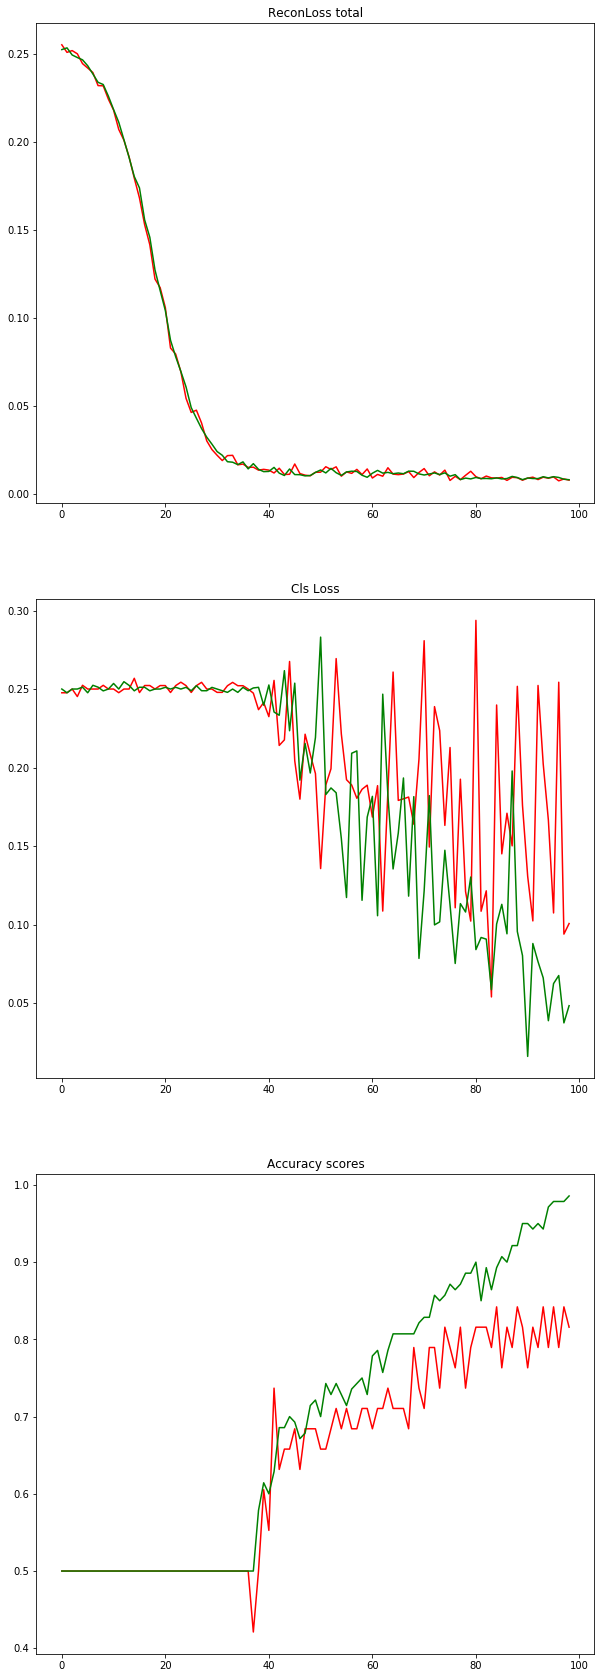

In [15]:
xrange = list(range(epoch))
width = 10
plt.figure(figsize=(1*width,3*width))
plt.subplot(311)
plt.plot(xrange,test_hist[:epoch,0],'r')
plt.plot(xrange,train_hist[:epoch,0],'g')
plt.title("ReconLoss total")
plt.subplot(312)
plt.plot(xrange,test_hist[:epoch,1],'r')
plt.plot(xrange,train_hist[:epoch,1],'g')
plt.title("Cls Loss")
plt.subplot(313)
plt.plot(xrange,test_hist[:epoch,2],'r')
plt.plot(xrange,train_hist[:epoch,2],'g')
plt.title("Accuracy scores")
plt.show()

35


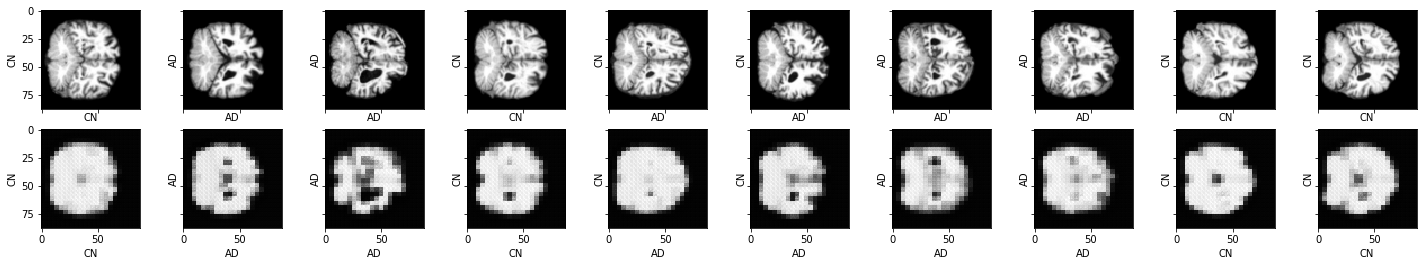

36


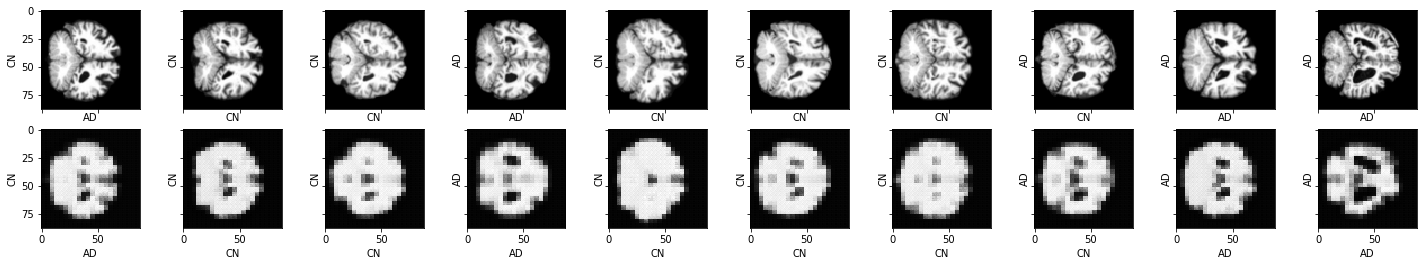

37


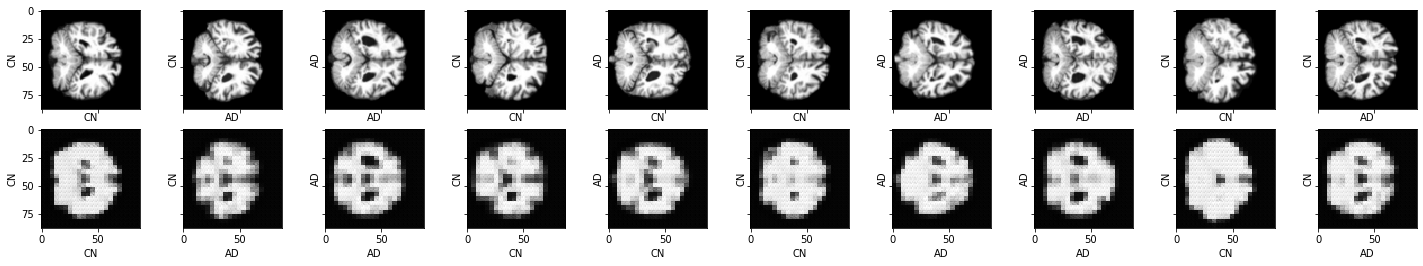

38


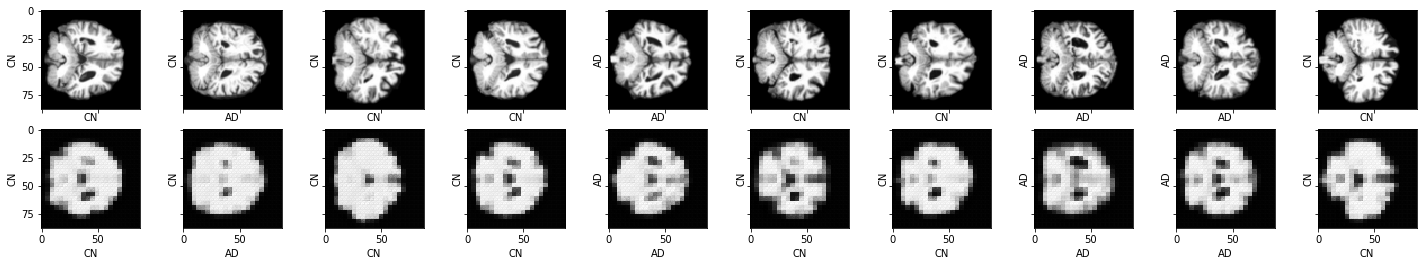

39


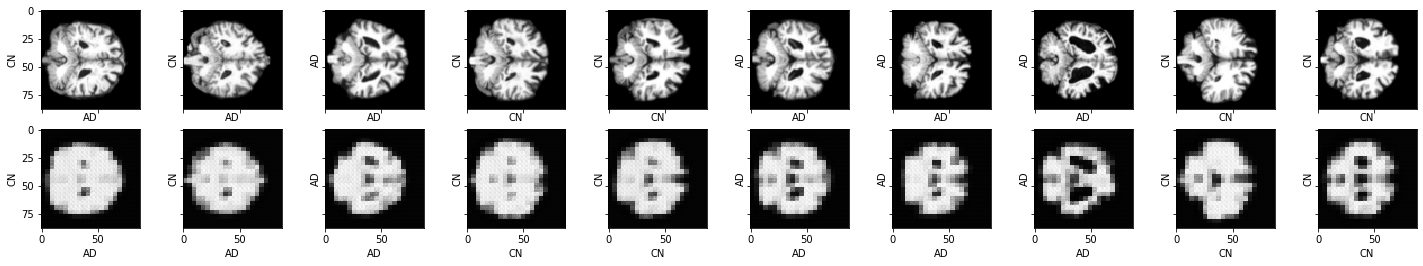

40


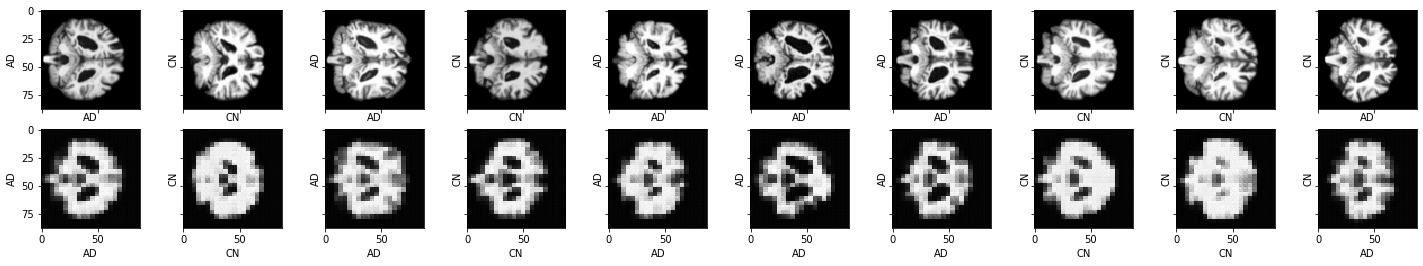

41


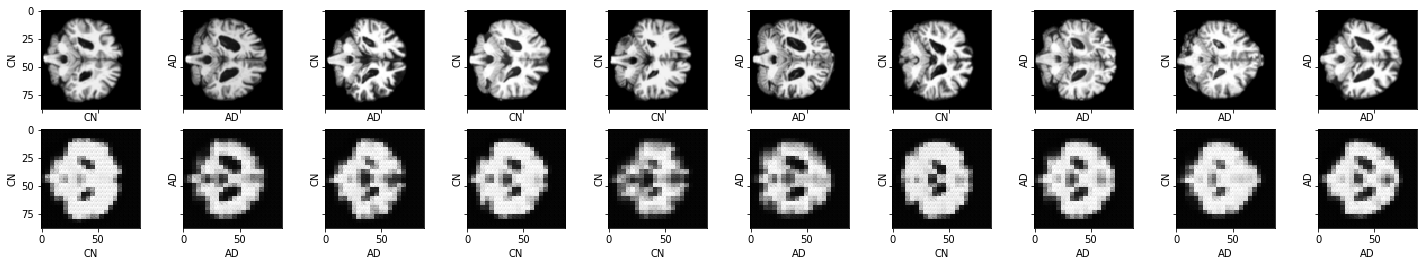

42


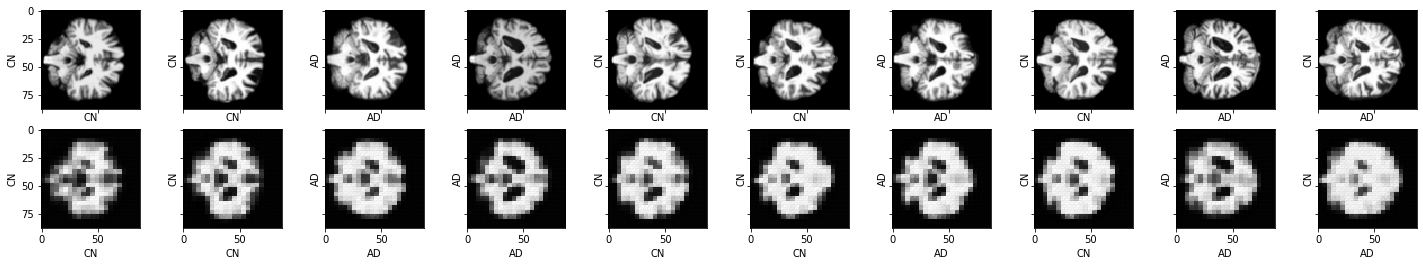

43


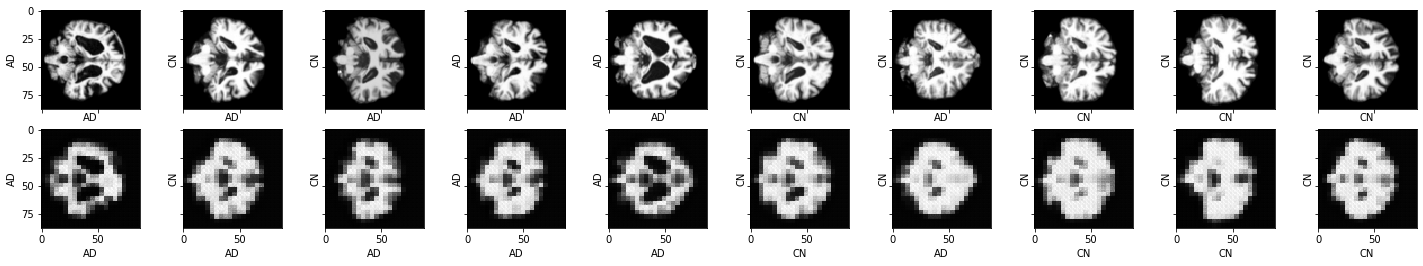

44


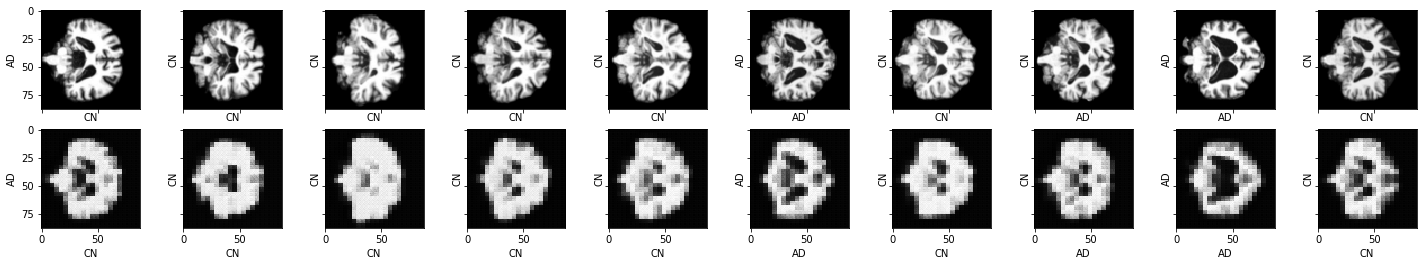

In [21]:
for slic in range(35,45):
    print(slic)
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    # print(labels)
    # get sample outputs
    model.eval()
    output,output2 = model(images)
    # print(output.shape)
    # prep images for display
    images = images.numpy()
    val, ind = output2.max(dim=1)
    # print(ind)
    # output is resized into a batch of iages
    # output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    # print(images.shape, output.shape)
    # input images on top row, reconstructions on bottom
    for images, row  in zip([images, output], axes):

        for idx,obj  in enumerate(zip(images, row)):
            img, ax= obj
            ax.imshow(np.squeeze(img[:,:,slic]), cmap='gray')
            ax.set_xlabel(list(diagnos.keys())[list(diagnos.values()).index(labels[idx])] )
            ax.set_ylabel(list(diagnos.keys())[list(diagnos.values()).index(ind[idx])] )
    #         ax.title(f"true {} ")
    #         ax.get_xaxis().set_visible(False)
    #         ax.get_yaxis().set_visible(False)
    plt.show()